In [14]:
from time import time
import unittest
import numpy as np
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 

from keras.datasets import mnist
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *
from util import importNotebook
from module.autoencoder import VAE, ConvVAE

In [15]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
numClass = 10
sizeDigit = xTrain.shape[1:]

dimInput = np.prod(xTrain.shape[1:])
xTrain = xTrain.reshape((numTrain, dimInput))
xTest = xTest.reshape((numTest, dimInput))
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


# Default parameters

In [ ]:
modelPath = '../model/temp/'
vae = VAE(dimInput)
history, timeTrain = vae.fit(xTrain, xTest,
                             tempPathBest=modelPath)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 188us/step - loss: 0.2561 - val_loss: 0.2258

Epoch 00001: val_loss improved from inf to 0.22584, saving model to ../model/temp/AutoEncoder.01-0.26-0.23.hdf5
Epoch 2/50
60000/60000 [==============================] - 10s 159us/step - loss: 0.2229 - val_loss: 0.2186

Epoch 00002: val_loss improved from 0.22584 to 0.21862, saving model to ../model/temp/AutoEncoder.02-0.22-0.22.hdf5
Epoch 3/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.2179 - val_loss: 0.2156

Epoch 00003: val_loss improved from 0.21862 to 0.21556, saving model to ../model/temp/AutoEncoder.03-0.22-0.22.hdf5
Epoch 4/50
60000/60000 [==============================] - 9s 157us/step - loss: 0.2147 - val_loss: 0.2128

Epoch 00004: val_loss improved from 0.21556 to 0.21278, saving model to ../model/temp/AutoEncoder.04-0.21-0.21.hdf5
Epoch 5/50
60000/60000 [==============================] - 9

In [ ]:
encoderVAE = vae.encoder
decoderVAE = vae.decoder

# Get encoded and decoded values
encodeTest = encoderVAE.predict(xTest)
decodeTest = decoderVAE.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

# Plot the comparison of original and reconstructed pictures, and calculate the errors
plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
err = compReconst(xTest, decodeTest, method='rmse')
print(err)

# Plot the scatter of the encoding space
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)    

# Plot the decoding results from the encoding scatter
plotScatterDecode(decoderVAE, sizeDigit, xlim, ylim)

In [ ]:
numEpochs = 100
sizeBatch = 32
sizeKernel = 3
layerDense = [64, 16, 4]
layerConv=[8, 32]
ratRecon = 1
nameOptim = 'adam'
modelPath = '../model/temp/'
patience = 3

(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
numClass = 10
sizeDigit = xTrain.shape[1:]

dimInput = [*xTrain.shape[1:], 1]
xTrain = xTrain.reshape((numTrain, *dimInput))
xTest = xTest.reshape((numTest, *dimInput))
print(xTrain.shape)
print(xTest.shape)

convVAE = ConvVAE(dimInput, layerDense=layerDense, layerConv=layerConv, ratRecon=ratRecon)
history, timeTrain = convVAE.fit(xTrain, xTest, 
                                 numEpochs=numEpochs,
                                 sizeBatch=sizeBatch,
                                 tempPathBest=modelPath)

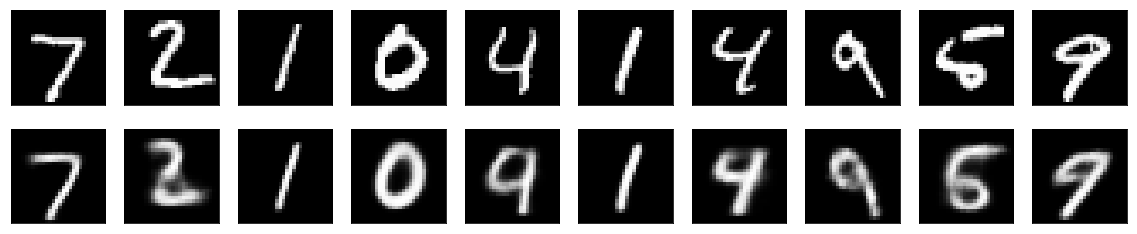

0.16177835


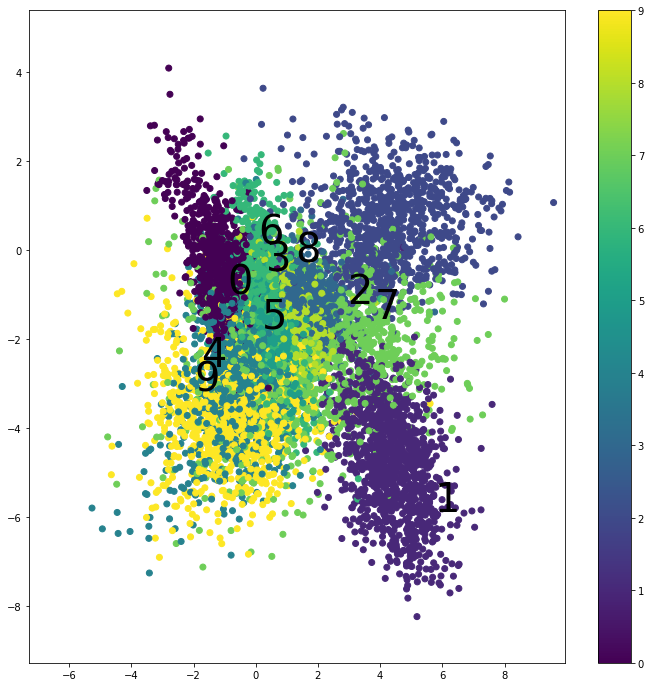

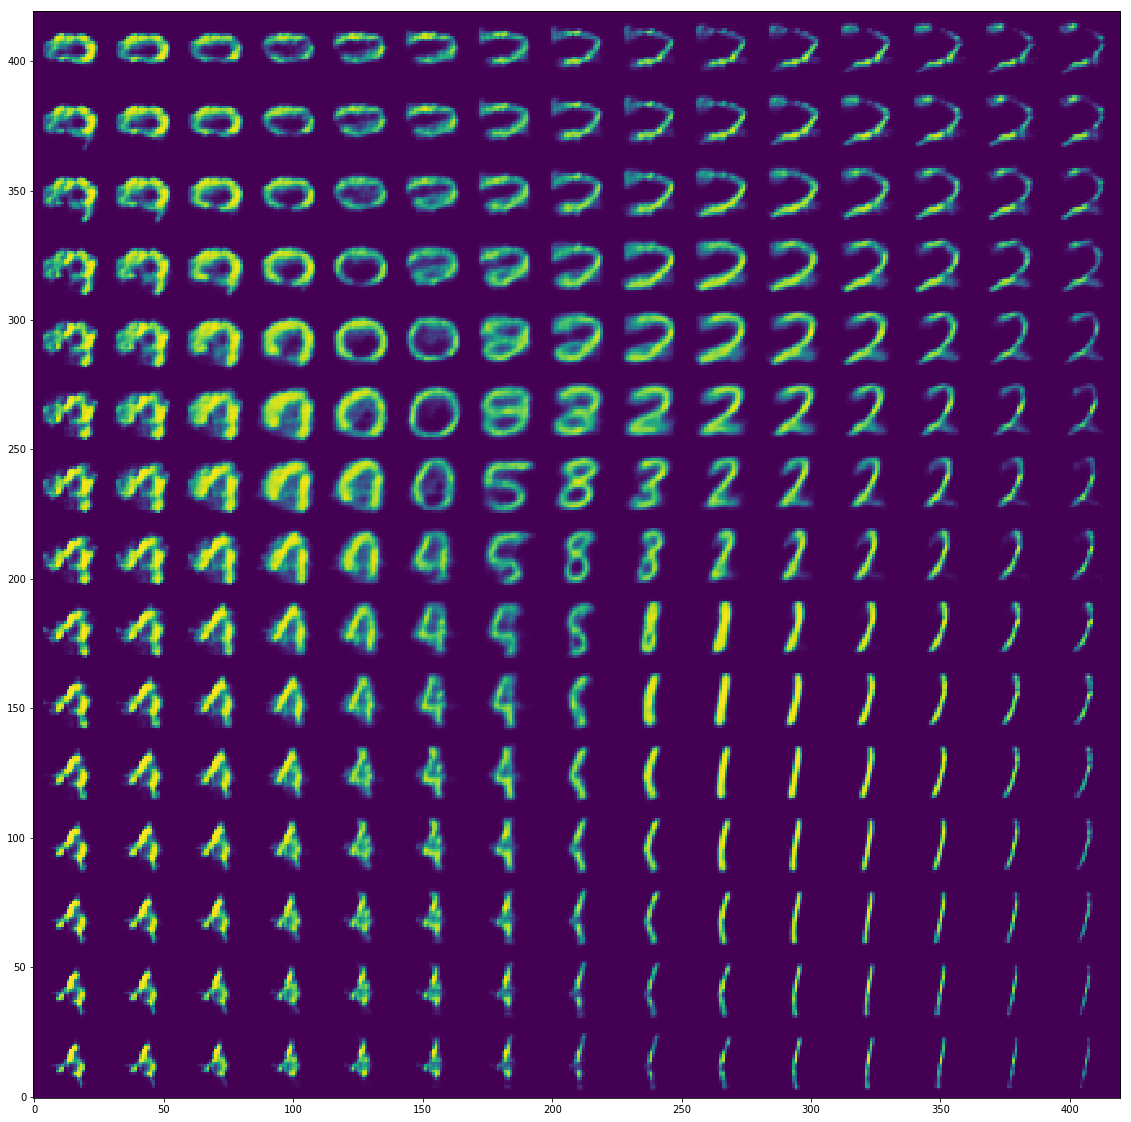

In [13]:
encoder = convVAE.encoder
decoder = convVAE.decoder

# Get encoded and decoded values
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

# Plot the comparison of original and reconstructed pictures, and calculate the errors
plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
err = compReconst(xTest, decodeTest, method='rmse')
print(err)

# Plot the scatter of the encoding space
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)    

# Plot the decoding results from the encoding scatter
plotScatterDecode(decoder, sizeDigit, xlim, ylim)